In [1]:
from DataGen import DataGenerator
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

In [2]:
# Hyperparameters
input_dim = (96, 96, 3)
z_dim = 100
disc_conv_filters = [16, 32, 64, 128]
disc_conv_kernels = [(3, 3), (3, 3), (3, 3), (3, 3)]
gen_conv_filters = [128, 64, 32, 3]
gen_conv_kernels = [(3, 3), (3, 3), (3, 3), (3, 3)]
lr = 0.002
batch_size = 256
epochs = 50

In [3]:
experiment_folder = os.path.abspath(os.path.join('..', 'Experimentos'))
model_name = 'GAN'
image_path = os.path.abspath(os.path.join('..', 'Dataset'))
data_path = os.path.join(image_path, 'wclasses.csv')

model_path = os.path.abspath(os.path.join(experiment_folder, model_name))
if not os.path.exists(model_path):
    os.mkdir(model_path)

if len(os.listdir(os.path.join(experiment_folder, model_name))) == 0:
    exp_id = 1
else:
    exp_id = len(os.listdir(os.path.join(experiment_folder, model_name))) + 1

current_experiment_path = os.path.join(experiment_folder, model_name, 'Exp_'+str(exp_id))
if not os.path.exists(current_experiment_path):
    os.mkdir(current_experiment_path)

In [4]:
hyperparams = {
    "input_dim":input_dim,
    "z_dim":z_dim,
    "disc_conv_filters":disc_conv_filters,
    "disc_conv_kernels":disc_conv_kernels,
    "gen_conv_filters":gen_conv_filters,
    "gen_conv_kernels":gen_conv_kernels,
    "learning rate":lr,
    "batch_size":batch_size,
    "epochs":epochs,
    "opt":"Adam",
    "loss":"binary_crossentropy",
    "data_path":data_path
}

with open(os.path.join(current_experiment_path, 'hyperparams.json'), 'w') as f:
    json.dump(hyperparams, f)

In [5]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape, disc_conv_filters, disc_conv_kernels, use_dropout=False):
    model = Sequential(name='Discriminator')
    for i in range(len(disc_conv_filters)):
        if i == 0:
            model.add(Conv2D(disc_conv_filters[i], disc_conv_kernels[i], strides=(2, 2), padding='same', input_shape=in_shape))
        else:
            model.add(Conv2D(disc_conv_filters[i], disc_conv_kernels[i], strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        if use_dropout:
            model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compilamos el modelo
    opt = Adam(learning_rate=lr, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [6]:
# definimos el generador
def define_generator(latent_dim, starting_dim, gen_conv_filters, gen_conv_kernels):
    model = Sequential(name='Generator')
    n_nodes = starting_dim[0] * starting_dim[1] * starting_dim[2]
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape(starting_dim))
    model.add(BatchNormalization())

    for i in range(len(gen_conv_filters)-1):
        model.add(Conv2DTranspose(gen_conv_filters[i], gen_conv_kernels[i], strides=(2,2), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(gen_conv_filters[-1], gen_conv_kernels[-1], activation='sigmoid', padding='same'))
    model.summary()
    return model

In [7]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):
    # Así que congelamos el discriminador:
    d_model.trainable = False
    # ahora conectamos el G(z) al D(x)
    model = Sequential()
    # añadimos el generador primero: él es el encargado de generar una muestra
    # a partir del espacio latente
    model.add(g_model)
    # y el discriminador después: le introducimos la muestra generada por el 
    # G(z) para que nos diga si cree que es real o fake
    model.add(d_model)
    # y ahora sí, compilamos el modelo
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr, beta_1=0.5)) 
    return model

In [8]:
# nos creamos una función que nos devuelva n_samples del dataset con sus 
# etiquetas (1) 
def generate_real_samples(dataset, i):
    X, _ = dataset[i]
    # generamos las etiquetas reales (1)
    y = np.ones((len(X), 1))
    return X, y

In [9]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch
    x_input = np.random.randn(latent_dim * batch_size)
    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples): 
    # usamos la función anterior para generar los vectores latentes que 
    # necesitamos para generar muestras fake
    x_input = generate_latent_points(latent_dim, n_samples)
    # le introducimos los vectores latentes al generador para obtener
    # muestras similares a las reales
    X = g_model.predict(x_input)
    print(X.shape)
    # le asignamos la etiqueta 0 (porque utilizaremos esta función para
    # entrenar el D)
    y = np.zeros((n_samples, 1)) 
    return X, y

In [10]:
# función para guardar las imágenes generadas
def save_plot(save_path, examples, epoch, n=10):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    # guardamos las imágenes
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    path = os.path.join(save_path, filename)
    plt.savefig(path)
    plt.close()

In [11]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, save_path, n_epochs=100, n_batch=256):
    history = {'generator_loss': [], 'discriminator_loss': []}
    for epoch in range(n_epochs):
        generator_step_losses = []
        discriminator_step_losses = []
        # bucle para los batch
        for batch in range(len(dataset)):
            # preparamos los datos reales
            X_real, y_real = generate_real_samples(dataset, batch)
            # generamos 'half_batch' datos falsos
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch//2)
            # juntamos las imágenes/etiquetas reales con las falsas
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # actualizamos los pesos del discriminador
            d_loss, _ = d_model.train_on_batch(X, y)
            discriminator_step_losses.append(d_loss)
            # preparamos los puntos en el espacio latente: serán la entrada al
            # modelo GAN con el que entrenaremos el generador
            X_gan = generate_latent_points(latent_dim, n_batch)
            # creamos etiquetas invertidas para el generador: utilizamos el D(x) 
            # para que piense que las muestras que le introducimos son reales, y
            # en caso de que diga que no son reales, aprovechamos la información
            # de sus gradientes para actualizar el G(z) para que la próxima vez
            # los datos generados por G(z) sean más plausibles (parecidos a los 
            # reales)
            y_gan = np.ones((n_batch, 1))
            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            generator_step_losses.append(g_loss)
            # mostramos el progreso
            clear_output(wait=True)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, len(dataset), d_loss, g_loss))
        history['generator_loss'].append(np.mean(generator_step_losses))
        history['discriminator_loss'].append(np.mean(discriminator_step_losses))
        print(f'Generator Mean Loss: {history["generator_loss"][-1]}, of {len(history["generator_loss"])}')
        print(f'Discriminator Mean Loss: {history["discriminator_loss"][-1]}, of {len(history["discriminator_loss"])}')
        # evaluamos el desempeño del modelo cada 10 épocas
        if (epoch+1) % 10 == 0 or epoch == 0:
            # preparamos ejemplos reales
            X_real, y_real = generate_real_samples(dataset, n_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
            # preparamos ejemplos fake
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            # guardamos las imágenes generadas
            save_plot(save_path, x_fake, epoch, n=5)
            # guardamos el generador para tenerlo disponible más tarde
            filename = 'generator_model_%03d.h5' % (epoch + 1)
            g_model.save(os.path.join(save_path, filename))
            filename = 'discriminator_model_%03d.h5' % (epoch + 1)
            d_model.save(os.path.join(save_path, filename))
            filename = 'gan_model_%03d.h5' % (epoch + 1)
            gan_model.save(os.path.join(save_path, filename))
    filename = 'generator_model.h5'
    g_model.save(os.path.join(current_experiment_path, filename))
    filename = 'discriminator_model.h5'
    d_model.save(os.path.join(current_experiment_path, filename))
    filename = 'gan_model.h5'
    gan_model.save(os.path.join(current_experiment_path, filename))
    return history

In [12]:
df = pd.read_csv(data_path, sep=',', encoding='ANSI')
# Load data
dataset = DataGenerator(df, path_to_img=image_path, batch_size=batch_size, width=input_dim[0], height=input_dim[1], channels=input_dim[2], shuffle=True)
# create the discriminator
d_model = define_discriminator(input_dim, disc_conv_filters, disc_conv_kernels, use_dropout=True)
# create the generator
g_model = define_generator(z_dim, (12, 12, 128), gen_conv_filters, gen_conv_kernels)
# create the gan
gan_model = define_gan(g_model, d_model)


Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 16)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)     

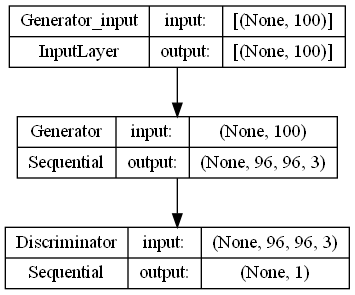

In [13]:
path = os.path.join(current_experiment_path, 'gan_generator.png')
plot_model(g_model, to_file=path, show_shapes=True)
path = os.path.join(current_experiment_path, 'gan_discriminator.png')
plot_model(d_model, to_file=path, show_shapes=True)
path = os.path.join(current_experiment_path, 'gan_complete.png')
plot_model(gan_model, to_file=path, show_shapes=True)

In [14]:
# train model
history = train(g_model, d_model, gan_model, dataset, z_dim, current_experiment_path, n_epochs=epochs, n_batch=batch_size)

>50, 637/637, d=0.702, g=1.312
Generator Mean Loss: 0.823470605807134, of 50
Discriminator Mean Loss: 0.7696376955209759, of 50
8/8 [==============================] - 0s 26ms/step
(256, 96, 96, 3)
>Accuracy real: 0%, fake: 100%


In [15]:
filename = 'generator_model.h5'
g_model.save(os.path.join(current_experiment_path, filename))
filename = 'discriminator_model.h5'
d_model.save(os.path.join(current_experiment_path, filename))
filename = 'gan_model.h5'
gan_model.save(os.path.join(current_experiment_path, filename))

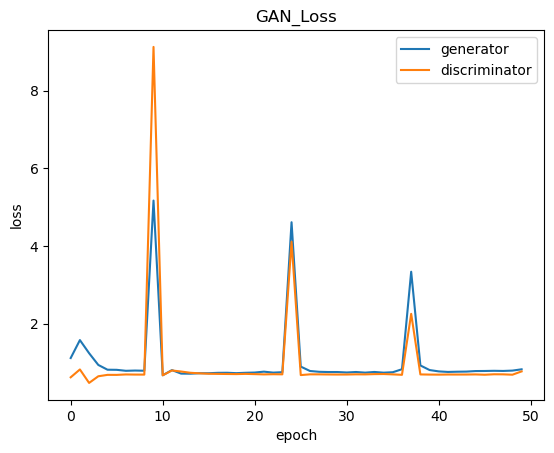

In [17]:
plt.plot(history['generator_loss'])
plt.plot(history['discriminator_loss'])
plt.title('GAN_Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'])
# guardamos las imágenes
filename = 'gan_loss.png'
path = os.path.join(current_experiment_path, filename)
plt.savefig(path)
plt.show()
plt.close()